# Description
*author:* Vina My Pham<br>
*supervisor:* Robin van der Weide<br>
*project:* MSc internship project<br>
<br>
*date:* January 15 - July 19, 2024<br>
*host:* Kind group, Hubrecht Institute<br>
*university:* Bioinformatics, Wageningen University & Research<br>

---
Script to compare manual annotations with predicted segmentations.

**Input**<br>
- manual segmentation (masks, .TIF)
- predicted segmentations (masks, .TIF) (either path to img or a directory containing the tifs).



**Output**<br>
A tab-delimited file with the following columns:

    model_type	manual_id	predicted_id	manual_size	predicted_size	intersection_size	union_size	jaccard_index	dice_coefficient

**Notes**<br>
- True positives: `manual_id` and `prediction_id` != -1
- False negatives: `manual_id` != -1, `prediction_id` = -1 (Jaccard Index = 0)
- False positives: `manual_id` = -1, `prediction_id` != 1


# Notebook initialisation

- Mounting the drive
- Installing Cellpose with `pip` (optional: `requirements.txt`)
- Importing modules
- Custom classes/functions

In [ ]:
#@markdown [mounting the notebook to the drive]
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)


Mounted at /content/gdrive


In [ ]:
#@markdown [Installing Cellpose and dependencies using pip and a `requirements.txt` file]<br>
#@markdown [runtime: ~3min]
from datetime import datetime

pip_requirements_path = "" #@param {type:"string"}

if len(pip_requirements_path) > 0:
    print(f"{datetime.now()}\tInstalling Cellpose using a requirements.txt")
    !pip install -r "$pip_requirements_path"
else:
    print(f"{datetime.now()}\tInstalling Cellpose v2.2.2")
    !pip install cellpose==2.2.2
print(f"{datetime.now()}\tFinished installing Cellpose")




2024-04-10 08:40:14.901192	Installing Cellpose v2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 15.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using ca

In [ ]:
#@markdown [imports]
print(f"{datetime.now()}\tImporting packages")

import os
from functools import cache
import copy
import numpy as np
import math
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from cellpose import utils, plot
from cellpose.io import imread

print(f"{datetime.now()}\tFinished importing packages")

2024-04-10 09:05:00.542783	Importing packages
2024-04-10 09:05:00.545266	Finished importing packages


# Custom classes and functions

In [ ]:
# markdown [code]

#helper functions
#_reformatting
def stacked(matrix):
    """Stack the channels of a image matrix

    Args:
        matrix (np.ndarray): image matrix (nChannels x nX x nY)
    Returns:
        np.ndarray: matrix representing the RGB format of an image (nX x nY)
    """
    return np.dstack((matrix[0,:,:], matrix[1,:,:], matrix[2,:,:]))

#_data loading
def parse_seg_npy_path_file(seg_npy_list_path, sep=","):
    """Retrieve image and mask matrices from _seg.npy files from a .txt file

    Args:
        seg_npy_list_path (str): path to the delimited file with columns:
                                    0. arbitrary identifier
                                    1. absolute path to the _seg.npy file
        sep (str): delimiter used in the file. Default: ","

    Returns:
        list of SegmentObject
    """
    segmentobjs = []

    with open(seg_npy_list_path, "r", encoding="UTF-8") as fileobj:
        for line in fileobj:
            name, path = line.strip("\n").split(sep)
            dat = np.load(path, allow_pickle=True).item()
            slice_obj = Slice(name, img_path = None, mask_path = None)
            slice_obj.img_matrix = dat["img"]
            slice_obj.mask_matrix = dat["masks"]
            segmentobjs.append(slice_obj)

    return segmentobjs

def parse_seg_npy_from_dir(seg_npy_dir):
    """Retrieve image and mask matrices from _seg.npy files in a directory

    Args:
        seg_npy_dir (str): path to the directory containing the seg_npy files

    Returns:
        list of SegmentObject
    """
    segmentobjs = []

    file_names = os.listdir(seg_npy_dir)
    for file_name in file_names:
        path = f"{seg_npy_dir}/{file_name}"
        name = file_name.split("_")[1]
        dat = np.load(path, allow_pickle=True).item()
        segmentobjs.append((SegmentObject(name, dat["img"], dat["masks"])))

    return segmentobjs


def load_masks(masks_paths, img_path=None, file_suffix='.tiff', sep=",", verbose=True):
    """Store mask matrices into SliceObjects

    Args:
        masks_paths (str): Path to directory path containing all mask TIFFs
                           or a .txt file containing paths to the mask TIFFs.
                           If .txt file: columns should be
                            0. identifier
                            1. absolute path to the mask TIFF file.
        file_suffix (str): file extension
        sep (str): delimiter used in the .txt file. Default: ","

    Returns:
        list of SegmentObject

    """
    slice_objs = []
    if os.path.isdir(masks_paths):
        #print(os.listdir(masks_paths))
        paths = [f"{masks_paths}/{mask_file}"
                 for mask_file in os.listdir(masks_paths)
                 if mask_file.endswith(file_suffix)]
        for path in paths:
            name=path.split('/')[-1].split('.')[0]
            if verbose: print(f"{datetime.now()}\t\tLoading {path}")
            slice_objs.append((Slice(name = name,
                                     img_path = img_path,
                                     mask_path = path)))
    else: #mask_paths is a file
        with open(masks_paths, "r", encoding="UTF-8") as fileobj:
            for line in fileobj:
                name, mask_path = line.strip("\n").split(sep)
                if verbose: print(f"{datetime.now()}\t\tLoading {mask_path}")
                slice_objs.append((Slice(name = name,
                                         img_path = img_path,
                                         mask_path = path)))

    return slice_objs

#_data analysis
def get_comparison_ids_within_region(reference_matrix, reference_id, comparison_matrix):
    """Return IDs from a matrix within a specific region in the reference matrix

    Args:
        matrices: 2d arrays of same size

    Returns:
        list of ints - IDs from the comparison matrix
    """
    search_window = comparison_matrix[np.where(reference_matrix == reference_id)]
    comparison_ids = list(np.unique(search_window))

    return comparison_ids

@cache
def get_overlapping_masks(reference_object, comparison_object,
                          reference_name='reference', comparison_name='comparison'):
    """Determine which masks from two matrices overlap with each other

    Args:
        reference_object: Object representing the reference matrix.
        comparison_object: Object representing the comparison matrix.

    Returns:
        pd.DataFrame: A DataFrame containing information about overlapping masks.
            The columns are as follows:
                - reference_id: ID of the mask in the reference matrix.
                - comparison_id: ID of the mask in the comparison matrix.
                - reference_size: Size of the mask in the reference matrix.
                - comparison_size: Size of the mask in the comparison matrix.
                - intersection_size: Size of the intersection between the masks.
                - union_size: Size of the union between the masks.
                - jaccard_index: Jaccard index calculated between the masks.
                - dice_coefficient: Dice coefficient calculated between the masks.
    """

    data_list = []

    reference_ids = list(np.unique(reference_object.mask_matrix))
    reference_ids.remove(0)

    for reference_id in reference_ids:
        reference_px = reference_object.mask_coords(reference_id)
        reference_tuples = list(map(tuple, reference_px))

        match_found=False

        #get comparison_ids within the region (computation efficiency)
        comparison_ids = get_comparison_ids_within_region(reference_object.mask_matrix,
                                                          reference_id,
                                                          comparison_object.mask_matrix)

        if 0 in comparison_ids:
            comparison_ids.remove(0)

        for comparison_id in comparison_ids:
            comparison_px = comparison_object.mask_coords(comparison_id)
            compare_tuples = list(map(tuple, comparison_px))

            intersection_px = set(reference_tuples).intersection(set(compare_tuples))


            if len(intersection_px) > 0 :
                match_found = True

                union_px = set(reference_tuples).union(set(compare_tuples))

                jaccard_index = len(intersection_px) / len(union_px)
                dice_coefficient = (2 * len(intersection_px)) / (len(reference_px) + len(comparison_px))

                data = {f"{reference_name}_id": reference_id ,
                        f"{comparison_name}_id": comparison_id,
                        f"{reference_name}_size": len(reference_px) ,
                        f"{comparison_name}_size": len(comparison_px),
                        "intersection_size": len(intersection_px),
                        "union_size": len(union_px),
                        "jaccard_index": jaccard_index,
                        "dice_coefficient": dice_coefficient}
                data_list.append(data)

        if not match_found:
            data = {f"{reference_name}_id": reference_id ,
                    f"{comparison_name}_id": -1,
                    f"{reference_name}_size": len(reference_px),
                    f"{comparison_name}_size": -1,
                    "intersection_size": -1,
                    "union_size": -1,
                    "jaccard_index": -1,
                    "dice_coefficient": -1}
            data_list.append(data)

    df = pd.DataFrame(data_list)

    return df

#_visualisation
def plot_masks(img, segmentobjs, subplot_size=(5,5), color='r', linewidth=0.7,
               padding=1.0):
    """Plot original image with outlines of input mask objects

    Args:
        img (numpy.ndarray): original image matrix
        segmentobjs (list): SegmentObjects to be plotted
        color (str): mask outline color. Default: 'r' (red)
        linewidth (float): mask outline width. Default: 0.7
        padding (float or int): figure padding. Default: 1.0

    Returns:
        matplotlib.figure.Figure with subplots, where
                                1. Original image, maskless
                                2+. Image overlayed with masks, in order of
                                    `segmentobjs` list.
    """
    n_subplots=len(segmentobjs)+1
    fig_width=subplot_size[0]*n_subplots
    fig_height= subplot_size[1]

    fig, axes = plt.subplots(1, n_subplots, figsize=(fig_width,fig_height))

    axes[0].imshow(img, cmap=plt.cm.gray)
    axes[0].set_title("original")
    axes[0].axis("off")

    for idx, segmentobj in enumerate(segmentobjs, 1):
        axes[idx].imshow(img, cmap=plt.cm.gray)
        outlines = utils.outlines_list(segmentobj.mask_matrix)
        for o in outlines:
            axes[idx].plot(o[:,0], o[:,1], color=color, linewidth=linewidth)
        axes[idx].set_title(segmentobj.name)
        axes[idx].axis("off")

    fig.tight_layout(pad=padding)
    plt.show();

    return fig

def compare_mask_id(ref_obj, comp_obj, mask_id, match_dict,
                 window_pad=10, ref_color = 'r', comp_color = 'black', linewidth=1.0, fig_pad=1):

    mask_px = comp_obj.mask_coords(mask_id)

    #viewing window
    x0, y0 = (min(mask_px[:,0])-window_pad, min(mask_px[:,1])-window_pad)
    x1, y1 = (max(mask_px[:,0])+window_pad, max(mask_px[:,1])+window_pad)
    img = comp_obj.img_matrix[:,x0:x1,y0:y1]

    mask_ref = copy.deepcopy(comp_obj.mask_matrix[x0:x1,y0:y1])
    mask_ref[~np.isin(mask_ref, [mask_id])] = 0

    comp_ref_ids = [k for k,v in match_dict.items() if v[0] == mask_id]
    comp_ref = copy.deepcopy(ref_obj.mask_matrix[x0:x1,y0:y1])
    comp_ref[~np.isin(comp_ref, comp_ref_ids)] = 0

    fig, axes = plt.subplots(1,4, figsize=(20,5))

    axes[0].imshow(stacked(img))
    axes[0].set_title("merged image")
    axes[0].axis("off")

    axes[1].imshow(img[1,:,:], cmap = plt.cm.gray)
    for o in utils.outlines_list(mask_ref):
        axes[1].plot(o[:,0], o[:,1], color=ref_color, linewidth=linewidth)
        axes[3].plot(o[:,0], o[:,1], color=ref_color, linewidth=linewidth)
    #axes[1].imshow(mask_ref, alpha=0.5)#, cmap=plt.cm.gray)
    axes[1].set_title(comp_obj.name)
    axes[1].axis("off")

    axes[2].imshow(img[1,:,:], cmap = plt.cm.gray)
    for o in utils.outlines_list(comp_ref):
        axes[2].plot(o[:,0], o[:,1], color=comp_color, linewidth=linewidth)
        axes[3].plot(o[:,0], o[:,1], color=comp_color, linewidth=linewidth)
    #axes[2].imshow(comp_ref, alpha=0.5, cmap=plt.cm.gray)
    axes[2].set_title(f"{ref_obj.name} {np.unique(comp_ref_ids)}")
    axes[2].axis("off")

    axes[3].imshow(img[1,:,:], cmap = plt.cm.gray)
    #axes[3].imshow(mask_ref, alpha=0.5)#, cmap=plt.cm.gray)
    #axes[3].imshow(comp_ref, alpha=0.5, cmap=plt.cm.gray)
    axes[3].set_title("overlay")
    axes[3].axis("off")

    plt.suptitle(f"{comp_obj.name} mask ID {mask_id}", y=0.95)
    plt.tight_layout(pad=fig_pad)
    plt.show();

    return fig

#__output
def save_plot(fig, fig_name, output_dir):
    """Write figure to a file

    Args:
        fig (matplotlib.figure.Figure): figure to be saved.
        fig_name (str): output file name, including filetype extension
        output_path (str): output directory for saving the figure

    Returns:
        str - full path to the saved file.

    Notes:
        - `output_dir` will be created if it does not exist
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_path = f"{output_dir}/{fig_name}"
    fig.savefig(file_path)

    return file_path

In [ ]:
class Slice:
    """Class for slices

    Attributes:
    name (str): Name of the slice
    img_path (str): Absolute path to the image file
    mask_path (str): Absolute path to the mask file

    Methods:
    matrix(matrix_type: str) -> np.ndarray:
        Retrieve the image or mask of the slice as a matrix

    show(mode: str = "",
            seg_channel: int = 2,
            subplot_size: tuple = (5,5)) -> None:
        Display the image and/or mask of the slice using matplotlib
    """
    def __init__(self, name: str, img_path: str, mask_path: str):
        """Initialise object

        Args:
            name (str): Name of the slice
            img_path (str, optional): Absolute path to the image file
            mask_path (str): Absolute path to the mask file
        """
        def load_matrices(filter=True, min_px=25):

            if isinstance(self.img_path, str):
                self.img_matrix = imread(img_path)
            if isinstance(self.mask_path, str):
                self.mask_matrix = reassign_ids(imread(mask_path))
                self.n_masks = len(np.unique(self.mask_matrix))

        self.name = name
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_matrix = None
        self.mask_matrix = None
        self.n_masks = None

        load_matrices()

    def __repr__(self):
        """Return the Object name if called"""
        return f"Slice(name='{self.name}')"

    def show(self,
            mode: str = "",
            seg_channel: int = 2,
            subplot_size: tuple = (5,5)) -> None:
        """Display the image and mask using matplotlib.

        Args:
            mode (str): Visualisation mode. Valid options:
                        "img": the original image (separate channels + merged)
                        "mask". the original image and mask outlines.
                        "": both "img" and "mask"
                        Default: ""
            seg_channel (int): channel used for segmentation - R:1, G:2, B:3.
                                Default: 2
            subplot_size (tuple): Size of the subplot_size (width, height).
                                    Default: (5, 5)
        """
        if mode not in ("", "mask", "img"):
            error_msg = f"Visualisation mode `{mode}` not recognised. Valid " +\
                        "options are ['', 'img', 'mask']"
            raise ValueError(error_msg)

        img_matrix = self.img_matrix
        merged_matrix = np.dstack((img_matrix[0,:,:], img_matrix[1,:,:], img_matrix[2,:,:]))

        #plot image (separate channels, merged)
        if mode in ("", "img"):
            n_subplots = img_matrix.shape[0]+1

            figsize = (subplot_size[0]*n_subplots, subplot_size[1])
            fig, axes = plt.subplots(1, n_subplots, figsize=figsize)

            #separate channels
            for i in range(0, n_subplots-1):
                axes[i].imshow(img_matrix[i,:,:], cmap=plt.cm.gray)
                axes[i].axis("off")
                axes[i].set_title(f"channel {i+1}")

                #merged
                axes[n_subplots-1].imshow(merged_matrix)
                axes[n_subplots-1].axis("off")
                axes[n_subplots-1].set_title("Merged")

                fig.suptitle(f"{self.name} - channels")
                fig.tight_layout()
                plt.show();

        #plot mask (original image, outlines)
        if mode in ("", "mask"):
            figsize = (subplot_size[0]*3, subplot_size[1])
            fig, axes = plt.subplots(1, 3, figsize=figsize)

            #original image
            axes[0].imshow(merged_matrix)
            axes[0].set_title("Merged")
            axes[0].axis("off")

            #channel used to segment
            axes[1].imshow(img_matrix[seg_channel-1,:,:], cmap=plt.cm.gray)
            axes[1].set_title(f"Channel {seg_channel}")
            axes[1].axis("off")

            #outlines
            outlines = utils.outlines_list(self.mask_matrix)
            axes[2].imshow(img_matrix[seg_channel-1,:,:], cmap=plt.cm.gray)
            for o in outlines:
                axes[2].plot(o[:,0], o[:,1], color='r', linewidth=0.7)
            axes[2].axis("off")
            axes[2].set_title("Masks")

            fig.suptitle(f"{self.name} - annotation")
            fig.tight_layout()
            plt.show();

        return None

    def mask_coords(self, mask_id):
        """Retrieve all pixel coordinates of a mask based on ID

        parameters:
            mask_id: int - ID of the single mask to inspect

        returns:
            np.ndarray - nested lists where a single nested list contains the [x,y]
                        coordinates
        """
        return np.column_stack(np.where(self.mask_matrix == mask_id))

# Loading the files


## 01.modelzoo

In [ ]:
#@markdown **Provide the path to the image file of the slice**
reference_img_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/pipeline_development/golden_standard/golden_standard_img.tif" #@param {type:"string"}

#@markdown **Provide the path to the manual segmentation of the slice**
manual_mask_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/pipeline_development/golden_standard/filtered_golden_standard_masks.tif" #@param {type:"string"}

#@markdown **Provide the path to the predictions**<br>
#@markdown either a directory containing the TIFFs, or a comma-delimited text file (col 0. custom name; col 1: mask path)
masks_paths = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401" #@param {type:"string"}

#@markdown **Provide a path to a directory for output of this notebook**
output_dir = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/02_model-selection/" #@param {type:"string"}

print(f"{datetime.now()}\tLoading files")
manual_segmentation = Slice(name = 'manual',
                     img_path = reference_img_path,
                     mask_path = manual_mask_path)
predictions = load_masks(masks_paths)
print(f"{datetime.now()}\tCompleted loading files")

2024-04-10 08:46:56.822136	Loading files
2024-04-10 08:47:01.725630		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/cyto_predictions.tiff
2024-04-10 08:47:04.367868		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/nuclei_predictions.tiff
2024-04-10 08:47:06.447213		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/tissuenet_predictions.tiff
2024-04-10 08:47:07.600870		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/livecell_predictions.tiff
2024-04-10 08:47:09.361066		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/cyto2_predictions.tiff
2024-04-10 08:47:11.537936		Loading /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/01_run-modelzoo/run20240401/general_predictions.tiff
2024-04-10 08:47:13.544186		Loading /content/gdrive/MyDr

## 2.model finetuning

In [ ]:
#@markdown **Provide the path to the image file of the slice**
reference_img_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/pipeline_development/golden_standard/golden_standard_img.tif" #@param {type:"string"}

#@markdown **Provide the path to the manual segmentation of the slice**
manual_mask_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/pipeline_development/golden_standard/golden_standard_masks.tif" #@param {type:"string"}

#@markdown **Provide the path to the predictions**<br>
#@markdown either a directory containing the TIFFs, or a comma-delimited text file (col 0. custom name; col 1: mask path)
masks_paths = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/03.5_finetuning_inspection/04022024/Copy of seg_npy_paths.csv" #@param {type:"string"}

#@markdown **Provide a path to a directory for output of this notebook**
output_dir = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/03.5_finetuning_inspection/04022024" #@param {type:"string"}

print(f"{datetime.now()}\tLoading files")
manual_segmentation = Slice(name = 'manual',
                     img_path = reference_img_path,
                     mask_path = manual_mask_path)
predictions = parse_seg_npy_path_file(masks_paths, sep=",")
print(f"{datetime.now()}\tCompleted loading files")

2024-04-03 21:12:47.790026	Loading files
2024-04-03 21:13:06.106841	Completed loading files


## Inspect loaded data

In [ ]:
#@markdown [code]
print("Loaded manual segmentation:")
print(manual_segmentation)

print("Loaded predictions:")
for idx, slice_obj in enumerate(predictions):
    print(f"\t{idx}\t{slice_obj}\t{slice_obj.mask_matrix.shape}")

Loaded manual segmentation:
Slice(name='manual')
Loaded predictions:
	0	Slice(name='cyto_predictions')	(1024, 1024)
	1	Slice(name='nuclei_predictions')	(1024, 1024)
	2	Slice(name='tissuenet_predictions')	(1024, 1024)
	3	Slice(name='livecell_predictions')	(1024, 1024)
	4	Slice(name='cyto2_predictions')	(1024, 1024)
	5	Slice(name='general_predictions')	(1024, 1024)
	6	Slice(name='CP_predictions')	(1024, 1024)
	7	Slice(name='CPx_predictions')	(1024, 1024)
	8	Slice(name='TN1_predictions')	(1024, 1024)
	9	Slice(name='TN2_predictions')	(1024, 1024)
	10	Slice(name='TN3_predictions')	(1024, 1024)
	11	Slice(name='LC1_predictions')	(1024, 1024)
	12	Slice(name='LC2_predictions')	(1024, 1024)
	13	Slice(name='LC3_predictions')	(1024, 1024)
	14	Slice(name='LC4_predictions')	(1024, 1024)


# Optionally, rename the slices


In [ ]:
for idx, slice_obj in enumerate(predictions):
    #print(f"\t{idx}\t{slice_obj}\t{slice_obj.mask_matrix.shape}")
    #new_name = input("new name: (leave empty if you dont want to rename it)")
    new_name=slice_obj.name.split("_predictions")[0]
    if new_name != "":
        slice_obj.name = new_name

print("After renaming, predictions:")
for idx, slice_obj in enumerate(predictions):
    print(f"\t{idx}\t{slice_obj}\t{slice_obj.mask_matrix.shape}")

After renaming, predictions:
	0	Slice(name='cyto')	(1024, 1024)
	1	Slice(name='nuclei')	(1024, 1024)
	2	Slice(name='tissuenet')	(1024, 1024)
	3	Slice(name='livecell')	(1024, 1024)
	4	Slice(name='cyto2')	(1024, 1024)
	5	Slice(name='general')	(1024, 1024)
	6	Slice(name='CP')	(1024, 1024)
	7	Slice(name='CPx')	(1024, 1024)
	8	Slice(name='TN1')	(1024, 1024)
	9	Slice(name='TN2')	(1024, 1024)
	10	Slice(name='TN3')	(1024, 1024)
	11	Slice(name='LC1')	(1024, 1024)
	12	Slice(name='LC2')	(1024, 1024)
	13	Slice(name='LC3')	(1024, 1024)
	14	Slice(name='LC4')	(1024, 1024)


#Show the segmentations next to each other

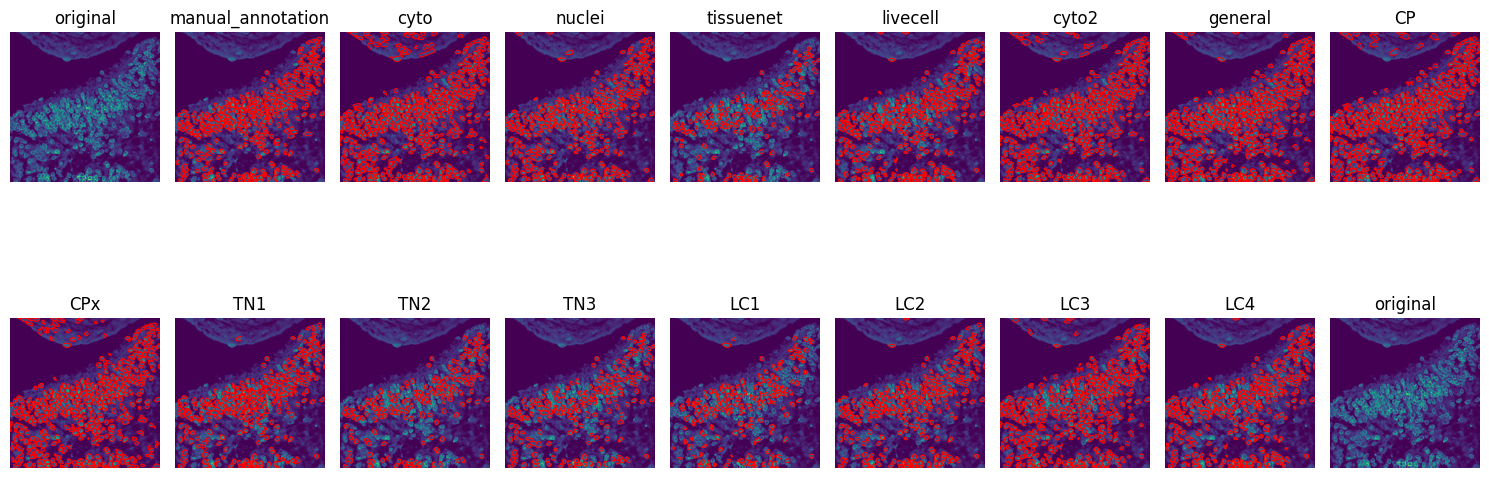

In [ ]:
plot_channel=1
nsubplots = 2 + len(predictions) #17
nrows = 2
ncols = math.ceil(nsubplots / nrows)
figsize=(15,7)

subplots_i = [(irow, icol) for irow in range(nrows) for icol in range(ncols)]

fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

irow, icol = subplots_i[0]
axes[irow, icol].imshow(manual_segmentation.img_matrix[plot_channel,:,:])
axes[irow, icol].axis("off")
axes[irow, icol].set_title("original")

for isubplot, slice_obj in zip(subplots_i[1:], [manual_segmentation]+predictions):
    irow, icol = isubplot
    axes[irow, icol].imshow(manual_segmentation.img_matrix[plot_channel,:,:])

    outlines = utils.outlines_list(slice_obj.mask_matrix)
    for o in outlines:
        axes[irow, icol].plot(o[:,0], o[:,1], color='r', linewidth=0.7)

    axes[irow, icol].axis("off")
    axes[irow, icol].set_title(slice_obj.name)

irow, icol = subplots_i[-1]
axes[irow, icol].imshow(manual_segmentation.img_matrix[plot_channel,:,:])
axes[irow, icol].axis("off")
axes[irow, icol].set_title("original")

plt.tight_layout()
plt.show();

# Match the masks


In [ ]:
def get_overlapping_masks(reference_object, comparison_object,
                          reference_name='reference', comparison_name='comparison'):
    """Determine which masks from two matrices overlap with each other

    Args:
        reference_object: Object representing the reference matrix.
        comparison_object: Object representing the comparison matrix.

    Returns:
        pd.DataFrame: A DataFrame containing information about overlapping masks.
            The columns are as follows:
                - reference_id: ID of the mask in the reference matrix.
                - comparison_id: ID of the mask in the comparison matrix.
                - reference_size: Size of the mask in the reference matrix.
                - comparison_size: Size of the mask in the comparison matrix.
                - intersection_size: Size of the intersection between the masks.
                - union_size: Size of the union between the masks.
                - jaccard_index: Jaccard index calculated between the masks.
                - dice_coefficient: Dice coefficient calculated between the masks.
    """

    data_list = []

    reference_ids = list(np.unique(reference_object.mask_matrix))
    reference_ids.remove(0)

    for reference_id in reference_ids:
        reference_px = reference_object.mask_coords(reference_id)
        reference_tuples = list(map(tuple, reference_px))

        match_found=False

        #get comparison_ids within the region (computation efficiency)
        search_window = comparison_object.mask_matrix[np.where(reference_object.mask_matrix == reference_id)]
        comparison_ids = list(np.unique(search_window))

        if 0 in comparison_ids:
            comparison_ids.remove(0)

        for comparison_id in comparison_ids:
            comparison_px = comparison_object.mask_coords(comparison_id)
            compare_tuples = list(map(tuple, comparison_px))

            intersection_px = set(reference_tuples).intersection(set(compare_tuples))


            if len(intersection_px) > 0 :
                match_found = True

                union_px = set(reference_tuples).union(set(compare_tuples))

                jaccard_index = len(intersection_px) / len(union_px)
                dice_coefficient = (2 * len(intersection_px)) / (len(reference_px) + len(comparison_px))

                data = {f"{reference_name}_id": reference_id ,
                        f"{comparison_name}_id": comparison_id,
                        f"{reference_name}_size": len(reference_px) ,
                        f"{comparison_name}_size": len(comparison_px),
                        "intersection_size": len(intersection_px),
                        "union_size": len(union_px),
                        "jaccard_index": jaccard_index,
                        "dice_coefficient": dice_coefficient}
                data_list.append(data)

        if not match_found:
            data = {f"{reference_name}_id": reference_id ,
                    f"{comparison_name}_id": -1,
                    f"{reference_name}_size": len(reference_px),
                    f"{comparison_name}_size": -1,
                    "intersection_size": -1,
                    "union_size": -1,
                    "jaccard_index": -1,
                    "dice_coefficient": -1}
            data_list.append(data)

    df = pd.DataFrame(data_list)

    return df

In [ ]:
all_matches = pd.DataFrame(columns=[
    'model_type',
    'manual_id',
    'predicted_id',
    'manual_size',
    'predicted_size',
    'intersection_size',
    'union_size',
    'jaccard_index',
    'dice_coefficient'])

for prediction in predictions:
    print(f"{datetime.now()}\tAnalysing {prediction.name}\tTP and FN")

    # Info on true positives, false negatives
    matches = get_overlapping_masks(manual_segmentation,
                                    prediction,
                                    reference_name='manual',
                                    comparison_name='predicted')
    matches['model_type'] = prediction.name
    all_matches = pd.concat([all_matches, matches], ignore_index=True)

    # Info on false positives
    print(f"{datetime.now()}\tAnalysing {prediction.name}\tFP")
    matches = get_overlapping_masks(prediction,
                                    manual_segmentation,
                                    reference_name='predicted',
                                    comparison_name='manual')
    matches['model_type'] = prediction.name
    false_positives = matches[matches['manual_id'] == -1]
    all_matches = pd.concat([all_matches, false_positives], ignore_index=True)


2024-04-10 09:55:31.989113	Analysing cyto	TP and FN
2024-04-10 09:55:32.068460	Analysing cyto	FP


In [ ]:
all_matches

,model_type,manual_id,predicted_id,manual_size,predicted_size,intersection_size,union_size,jaccard_index,dice_coefficient
0,cyto,1,367,1043,1897,3,2937,0.001021,0.002041
1,cyto,1,372,1043,1489,998,1534,0.650587,0.788310
2,cyto,1,384,1043,812,42,1813,0.023166,0.045283
3,cyto,-1,1,-1,1181,-1,-1,-1.000000,-1.000000


# write all_matches to a txt file

In [ ]:
all_matches.to_csv(f'{output_dir}/all_matches.txt', sep='\t', index=False)